## Applying GPR to the mean, var,skw, kurt data

### Step 1: data acqusition


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.misc import derivative
import matplotlib.pyplot as plt

matrix= scipy.io.loadmat("/Users/Jayee/Downloads/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
x_exp= np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)


In [26]:
maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = x_exp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]


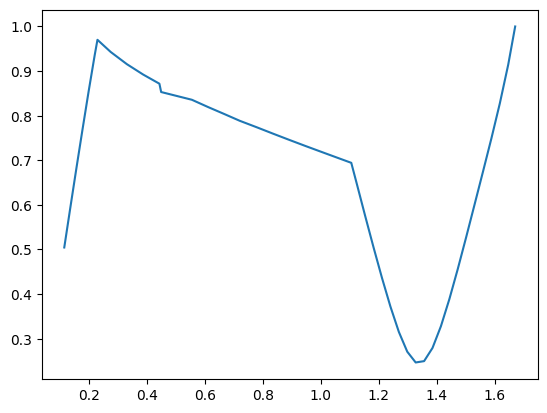

In [28]:
plt.plot(tExpTrunc,xExpTruncNormal[:,0])

### Step 2: Let us import the neural functions

In [29]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

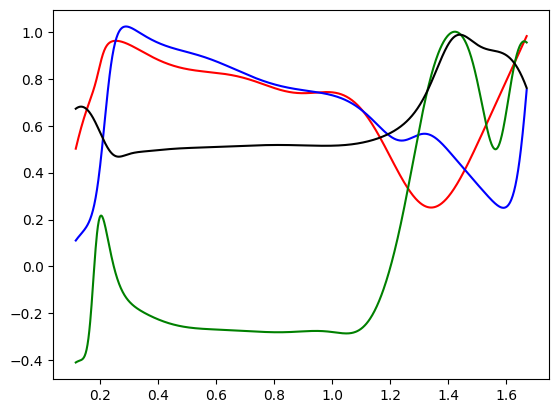

In [31]:
interpolMeanNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolVarNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolSkwNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolKurtNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolMeanNN.load_state_dict(torch.load("/Users/Jayee/Desktop/PhD/Projects/PhD/GPR/240514_meeting_prep/interpolMean_64_64.pth"))
interpolVarNN.load_state_dict(torch.load("/Users/Jayee/Desktop/PhD/Projects/PhD/GPR/240514_meeting_prep/interpolVar_64_64.pth"))
interpolSkwNN.load_state_dict(torch.load("/Users/Jayee/Desktop/PhD/Projects/PhD/GPR/240514_meeting_prep/interpolSkw_64_64.pth"))
interpolKurtNN.load_state_dict(torch.load("/Users/Jayee/Desktop/PhD/Projects/PhD/GPR/240514_meeting_prep/interpolKurt_64_64.pth"))

interpolMeanNN.eval()
interpolVarNN.eval()
interpolSkwNN.eval()
interpolKurtNN.eval()

x_test = torch.unsqueeze(torch.linspace(0.1156, 1.670, 1000), dim=1).double()
y_test1 = interpolMeanNN(x_test)
y_test2 = interpolVarNN(x_test)
y_test3 = interpolSkwNN(x_test)
y_test4 = interpolKurtNN(x_test)


plt.plot(x_test, y_test1.detach().numpy(), 'r')
plt.plot(x_test, y_test2.detach().numpy(), 'b')
plt.plot(x_test, y_test3.detach().numpy(), 'g')
plt.plot(x_test, y_test4.detach().numpy(), 'k')
plt.show()

### Step 3: Collect data uniformly spaced in the phase portrait

We wish to collect data spaced uniformly in the phase portrait. This requires us to calculate the speed at every instant.

In [55]:
from torchvision import models
from torch.autograd import Variable

def dm_dt(time):
    t = torch.tensor([time], dtype=torch.float64,requires_grad=True)
    output = interpolMeanNN(t)
    output.backward()
    derivative = t.grad
    return derivative.item()

def dv_dt(time):
    t = torch.tensor([time], dtype=torch.float64,requires_grad=True)
    output = interpolVarNN(t)
    output.backward()
    derivative = t.grad
    return derivative.item()

def ds_dt(time):
    t = torch.tensor([time], dtype=torch.float64,requires_grad=True)
    output = interpolSkwNN(t)
    output.backward()
    derivative = t.grad
    return derivative.item()

def dk_dt(time):
    t = torch.tensor([time], dtype=torch.float64,requires_grad=True)
    output = interpolKurtNN(t)
    output.backward()
    derivative = t.grad
    return derivative.item()

In [93]:
n_UT = 1e6
n_UT = int(n_UT)
t_span = torch.tensor(np.linspace(0.1156, 1.670, n_UT), dtype=torch.float64)
t_span = t_span.reshape(-1,1)
m_UT,v_UT = interpolMeanNN(t_span),interpolVarNN(t_span)
s_UT,k_UT = interpolSkwNN(t_span),interpolKurtNN(t_span)



In [102]:
#total length of the phase portrait
dm_UT = m_UT[1:]-m_UT[:-1]
dv_UT = v_UT[1:]-v_UT[:-1]
ds_UT = s_UT[1:]-s_UT[:-1]
dk_UT = k_UT[1:]-k_UT[:-1]

segments = torch.sqrt(dm_UT**2+dv_UT**2+ds_UT**2+dk_UT**2)
total_length = sum(segments)

In [103]:
total_length

tensor([5.3028], dtype=torch.float64, grad_fn=<AddBackward0>)

Now let us collect 100 equally spaced data points for the sake of training.
How do we collect 100 equally spaced data points?

In [421]:
#total_length = total_length.item()
n_UD = 25
segment_length = total_length/(n_UD-1)
dl = 0
index= np.zeros(100)
UD_index = 1
UT_index = 0
for _ in segments:
    dl = dl + _
    if dl >= segment_length:
        dl = 0
        index[UD_index] = UT_index
        UD_index = UD_index+1
    UT_index = UT_index+1

index[-1]=n_UT-1
index=index.astype(np.int64)

In [422]:
m_UT = m_UT.detach().numpy()
v_UT = v_UT.detach().numpy()
s_UT = s_UT.detach().numpy()
k_UT = k_UT.detach().numpy()


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

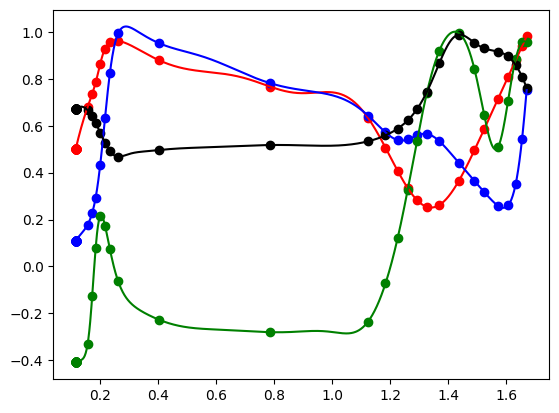

In [423]:
plt.plot(t_span[index],m_UT[index], "ro")
plt.plot(t_span[index],v_UT[index], "bo")
plt.plot(t_span[index],s_UT[index], "go")
plt.plot(t_span[index],k_UT[index], "ko")
plt.plot(x_test, y_test1.detach().numpy(), 'r')
plt.plot(x_test, y_test2.detach().numpy(), 'b')
plt.plot(x_test, y_test3.detach().numpy(), 'g')
plt.plot(x_test, y_test4.detach().numpy(), 'k')
plt.show()

### Step 4: creating the x_train and y_train


In [424]:
t_train = t_span[index[:-2]].numpy().reshape(1,-1)
m_train = m_UT[index[:-2]].reshape(1,-1)
v_train = v_UT[index[:-2]].reshape(1,-1)
s_train = s_UT[index[:-2]].reshape(1,-1)
k_train = k_UT[index[:-2]].reshape(1,-1)
x_train = np.vstack([m_train,v_train,s_train,k_train,t_train])

x_train = np.transpose(x_train)

m_train = m_UT[index[:-2]+1000].reshape(1,-1)
v_train = v_UT[index[:-2]+1000].reshape(1,-1)
s_train = s_UT[index[:-2]+1000].reshape(1,-1)
k_train = k_UT[index[:-2]+1000].reshape(1,-1)

y_train = np.vstack([m_train,v_train,s_train,k_train])
y_train = np.transpose(y_train)

dt = t_span[1000,0].item()-t_span[0,0].item()

### Step 5: Calculating individual GPRs
#### Step 5a: Preprocessing and scaling


In [425]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled =x_scaler.transform(x_train)

#### Step 5b: GPR for mean

In [491]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF

kernel_m = 1*RBF(length_scale=[1,1,1,1,0.1],length_scale_bounds=[1e-9,1e9])
gp_m = GPR(kernel=kernel_m,n_restarts_optimizer=10,random_state=1)
gp_m.max_iter_predict = 100

gp_m.fit(x_train_scaled,y_train[:,0])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 0.1]),
                         n_restarts_optimizer=10, random_state=1)

In [492]:
gp_m.kernel_

0.69**2 * RBF(length_scale=[1.21, 2.41, 10.1, 10.4, 33.6])

#### Step 5c: GPR for Variance

In [428]:
kernel_v = 1*RBF(length_scale=[1,1,1,1,1],length_scale_bounds=[1e-9,1e9])
gp_v = GPR(kernel=kernel_v,n_restarts_optimizer=10,random_state=1)
gp_v.max_iter_predict = 100

gp_v.fit(x_train_scaled,y_train[:,1])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1]),
                         n_restarts_optimizer=10, random_state=1)

In [429]:
gp_v.kernel_

1.13**2 * RBF(length_scale=[3.75, 2.84, 12.8, 22.6, 7.2])

#### Step 5d: GPR for Skewness

In [430]:
kernel_s = 1*RBF(length_scale=[1,1,1,1,10],length_scale_bounds=[1e-9,1e5])
gp_s = GPR(kernel=kernel_s,n_restarts_optimizer=10,random_state=1)
gp_s.max_iter_predict = 10000

gp_s.fit(x_train_scaled,y_train[:,2])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 10]),
                         n_restarts_optimizer=10, random_state=1)

In [431]:
gp_s.kernel_

1.41**2 * RBF(length_scale=[6.52, 9.39, 0.99, 2.09, 59.7])

#### Step 5e: GPR for kurtosis

In [432]:
kernel_k = 1*RBF(length_scale=[1,1,1,1,10],length_scale_bounds=[1e-9,1e2])
gp_k = GPR(kernel=kernel_k,n_restarts_optimizer=10,random_state=1)
gp_k.max_iter_predict = 1000

gp_k.fit(x_train_scaled,y_train[:,3])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 10]),
                         n_restarts_optimizer=10, random_state=1)

In [433]:
gp_k.kernel_

1.5**2 * RBF(length_scale=[6.81, 11.6, 7.51, 6.39, 14.7])

### Step 6: Prediction from GPR

In [487]:
ic = np.array([m_train[0,0],v_train[0,0],s_train[0,0],k_train[0,0],t_train[0,0]])
ic = np.transpose(ic.reshape(-1,1))
ic_scaled = x_scaler.transform(ic)

n_pred = int((max(max(t_train))-min(min(t_train)))/dt)

t_pred= np.zeros(n_pred)
t_pred[0] = min(min(t_train))

x_pred = np.zeros([n_pred,5])
x_pred[0,:]=ic
x_pred_scaled = x_scaler.transform(ic)
for _ in range(n_pred):
    t_pred[_+1] = t_pred[_]+dt
    mean_mean_pred,mean_std_pred = gp_m.predict(x_pred_scaled,return_std=True)
    var_mean_pred,var_std_pred = gp_v.predict(x_pred_scaled,return_std=True)
    skw_mean_pred,skw_std_pred = gp_s.predict(x_pred_scaled,return_std=True)
    kurt_mean_pred,kurt_std_pred = gp_k.predict(x_pred_scaled,return_std=True)
    x_pred_scaled =np.array([mean_mean_pred,var_mean_pred,skw_mean_pred,kurt_mean_pred,np.array([t_pred[index]])])
    x_pred_scaled =  x_pred_scaled.reshape(1,-1)
    x_pred[_,:] = x_pred_scaled
    x_pred_scaled = x_scaler.transform(x_pred_scaled)

IndexError: index 989 is out of bounds for axis 0 with size 989

In [488]:
x_pred

array([[ 0.51787493,  0.11591251, -0.40683694,  0.67502719,  0.1171544 ],
       [ 0.52562851,  0.11843165, -0.40621751,  0.67622584,  0.1171544 ],
       [ 0.53326666,  0.12092652, -0.40586448,  0.67729603,  0.1171544 ],
       ...,
       [-0.33746227,  1.22004667,  0.13813438, -1.93538335,  0.1171544 ],
       [-0.33746227,  1.22004667,  0.13813438, -1.93538335,  0.1171544 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [470]:
kurt_mean_pred

array([0.67502719])

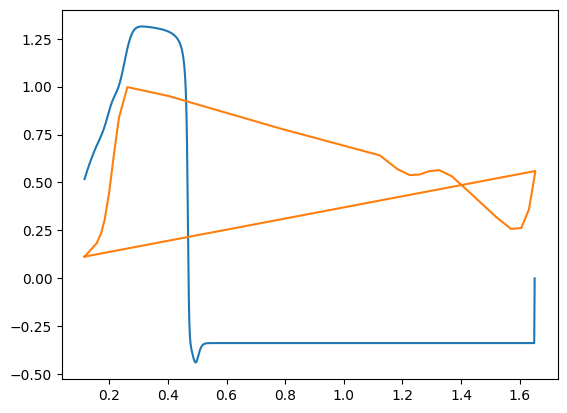

In [490]:
plt.plot(t_pred,x_pred[:,0])
plt.plot(t_train[0,:-1],v_train[0,:-1])

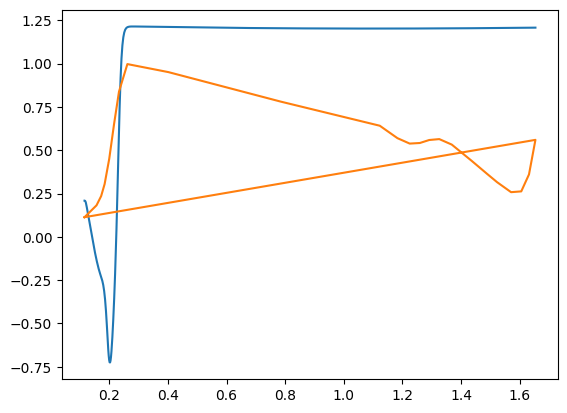

In [438]:
plt.plot(t_pred,var_mean_pred)
plt.plot(t_train[0,:],v_train[0,:])

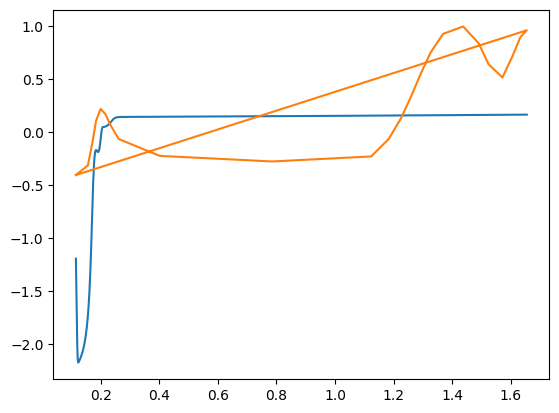

In [439]:
plt.plot(t_pred,skw_mean_pred)
plt.plot(t_train[0,:],s_train[0,:])

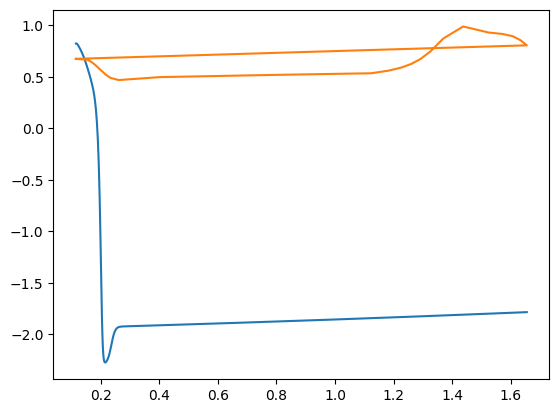

In [440]:
plt.plot(t_pred,kurt_mean_pred)
plt.plot(t_train[0,:],k_train[0,:])

In [441]:
mean_mean_Pred[0]


0.5564543614740387